In [37]:
# Libraries and stuff

import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib import ticker

import netCDF4
from netCDF4 import Dataset

# Remove warning and live a happy life
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [38]:
from matplotlib import dates
from datetime import date, timedelta
import pandas as pd

When considering many time series we face a multiple testing problem and more and more false positives
are expected in the statistical inference. To control the ratio of false positives we adopt
the False Discovery Rate (FDR) test proposed by Benjamini and Hochberg [1995].

Here we give an example of such procedure in the case of GFDL-CM4 model in the 1pctCO2 run.

We consider both the zos and zos + ib field in the last 100 years of a 150 years long run forced with 1% per year increase in CO2 since preindustrial.

We focus on both dynamic sea level (zos) and when the inverse barometer is included (zos + ib)

# Main analysis

## Load data

Results generated using n = 1000 bootstrapped samples. The two-tailed statistical significance are computed at the 95% significance level (no account for multiple testing).

In [39]:
import utils_load_data

In [40]:
# We load results of quantile regression

# These results have been computed on the server

#path_results = '../from_cluster/zos_plus_ib_B1000.npy'
path_results_zosOnly = './computed/zos_only_B1000_blocks_1season.npy'
path_results_zosIB = './computed/zos_plus_ib_B1000_blocks_1season.npy'
zos_only = np.load(path_results_zosOnly,allow_pickle=True)
zos_ib = np.load(path_results_zosIB,allow_pickle=True)

# ZOS

# Slopes for [mean,variance,skewness,kurtosis]
zos_only_a = np.array(zos_only[:,0].tolist())*365000 # From m/day to mm/year
# Two-tailed significance (no multiple testing)
zos_only_t_test = np.array(zos_only[:,1].tolist())
# Distribution for [mean,variance,zos_results_JJA,kurtosis]
zos_only_a_distribution = np.array(zos_only[:,2].tolist())*365000 # From m/day to mm/year

# Slopes for [mean,variance,skewness,kurtosis]
zos_ib_a = np.array(zos_ib[:,0].tolist())*365000 # From m/day to mm/year
# Two-tailed significance (no multiple testing)
zos_ib_t_test = np.array(zos_ib[:,1].tolist())
# Distribution for [mean,variance,zos_results_JJA,kurtosis]
zos_ib_a_distribution = np.array(zos_ib[:,2].tolist())*365000 # From m/day to mm/year

## Multiple testing

In [41]:
import utils_significance

### Simple approach 

In [43]:
p_values_zosOnly = utils_significance.p_values(zos_only_a,zos_only_a_distribution)
p_values_zosIB = utils_significance.p_values(zos_ib_a,zos_ib_a_distribution)

phi = [0.05,0.05,0.05,0.05]
significance_pv_zosOnly = utils_significance.fdr_significance_4_moments(p_values_zosOnly,phi)
significance_pv_zosIB = utils_significance.fdr_significance_4_moments(p_values_zosIB,phi)

In [44]:
# Define False Discovery Rate
phi = [0.05,0.05,0.05,0.05] 

# We are looking at the first 4 moments
moments = ['Mean','Variance','Skewness','Kurtosis']

# Total number of time series analyzed?
print('Total number of time series: '+str(len(significance_pv_zosOnly)))

print('')
for i in range(len(moments)):
    fdr = phi[i]
    print('########## '+str(moments[i]))
    print('')
    print('ZOS only')
    print('FDR. # of statistical significant changes '+str(np.sum(significance_pv_zosOnly[:,i])))
    print('2 tailed test. # of statistical significant changes '+str(np.sum(zos_only_t_test[:,i])))
    print('')
    print('ZOS + IB')
    print('FDR. # of statistical significant changes '+str(np.sum(significance_pv_zosIB[:,i])))
    print('2 tailed test. # of statistical significant changes '+str(np.sum(zos_ib_t_test[:,i])))
    print('')

Total number of time series: 6318

########## Mean

ZOS only
FDR. # of statistical significant changes 4939
2 tailed test. # of statistical significant changes 5006

ZOS + IB
FDR. # of statistical significant changes 4260
2 tailed test. # of statistical significant changes 4412

########## Variance

ZOS only
FDR. # of statistical significant changes 293
2 tailed test. # of statistical significant changes 1131

ZOS + IB
FDR. # of statistical significant changes 632
2 tailed test. # of statistical significant changes 1530

########## Skewness

ZOS only
FDR. # of statistical significant changes 315
2 tailed test. # of statistical significant changes 1135

ZOS + IB
FDR. # of statistical significant changes 914
2 tailed test. # of statistical significant changes 1731

########## Kurtosis

ZOS only
FDR. # of statistical significant changes 18
2 tailed test. # of statistical significant changes 531

ZOS + IB
FDR. # of statistical significant changes 394
2 tailed test. # of statistical signifi

By controlling the False Discovery Rate we have way less statistically significant changes. Those changes were probably just False Positives.

## Plot p-values and FDR

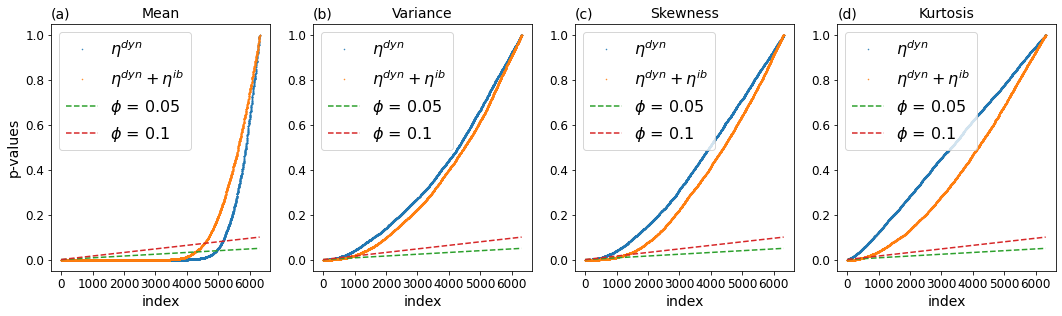

In [45]:
fontsize_title = 14
fontsize_ticks = 12
fontsize_labels = 14
fontsize_legend = 16
font_size_letter = 12
point_size = 1

fig = plt.figure(figsize=(18,10))

ax = fig.add_subplot(241)
moment = 0
plt.plot(np.arange(1,len(p_values_zosOnly)+1),np.sort(p_values_zosOnly[:,moment]),'.',markersize = point_size,label = '$\eta^{dyn}$')
plt.plot(np.arange(1,len(p_values_zosIB)+1),np.sort(p_values_zosIB[:,moment]),'.',markersize = point_size,label = '$\eta^{dyn} + \eta^{ib}$')
q = 0.05
plt.plot(np.arange(1,len(p_values_zosOnly)+1),utils_significance.fdr_ratio(q,len(p_values_zosOnly)),'--',label = '$\phi$ = 0.05')
q = 0.1
plt.plot(np.arange(1,len(p_values_zosIB)+1),utils_significance.fdr_ratio(q,len(p_values_zosIB)),'--',label = '$\phi$ = 0.1')

ax.legend(fontsize = fontsize_legend)
plt.xlabel('index',fontsize = fontsize_labels)
plt.ylabel('p-values',fontsize = fontsize_labels)
#plt.xlabel('FDR $\phi$',fontsize = fontsize_labels)
plt.title('Mean',fontsize = fontsize_title)
plt.title('(a)',loc='left',fontsize = fontsize_title)
plt.xticks(fontsize = fontsize_ticks)
plt.yticks(fontsize = fontsize_ticks)

ax = fig.add_subplot(242)
moment = 1
plt.plot(np.arange(1,len(p_values_zosOnly)+1),np.sort(p_values_zosOnly[:,moment]),'.',markersize = point_size,label = '$\eta^{dyn}$')
plt.plot(np.arange(1,len(p_values_zosIB)+1),np.sort(p_values_zosIB[:,moment]),'.',markersize = point_size,label = '$\eta^{dyn} + \eta^{ib}$')
q = 0.05
plt.plot(np.arange(1,len(p_values_zosOnly)+1),utils_significance.fdr_ratio(q,len(p_values_zosOnly)),'--',label = '$\phi$ = 0.05')
q = 0.1
plt.plot(np.arange(1,len(p_values_zosIB)+1),utils_significance.fdr_ratio(q,len(p_values_zosIB)),'--',label = '$\phi$ = 0.1')

ax.legend(fontsize = fontsize_legend)
#plt.xlabel('FDR $\phi$',fontsize = fontsize_labels)
plt.xlabel('index',fontsize = fontsize_labels)
plt.title('Variance',fontsize = fontsize_title)
plt.title('(b)',loc='left',fontsize = fontsize_title)
plt.xticks(fontsize = fontsize_ticks)
plt.yticks(fontsize = fontsize_ticks)
#plt.xlim([0,20])
#plt.ylim([-0.001,0.05])

ax = fig.add_subplot(243)
moment = 2
plt.plot(np.arange(1,len(p_values_zosOnly)+1),np.sort(p_values_zosOnly[:,moment]),'.',markersize = point_size,label = '$\eta^{dyn}$')
plt.plot(np.arange(1,len(p_values_zosIB)+1),np.sort(p_values_zosIB[:,moment]),'.',markersize = point_size,label = '$\eta^{dyn} + \eta^{ib}$')
q = 0.05
plt.plot(np.arange(1,len(p_values_zosOnly)+1),utils_significance.fdr_ratio(q,len(p_values_zosOnly)),'--',label = '$\phi$ = 0.05')
q = 0.1
plt.plot(np.arange(1,len(p_values_zosIB)+1),utils_significance.fdr_ratio(q,len(p_values_zosIB)),'--',label = '$\phi$ = 0.1')

ax.legend(fontsize = fontsize_legend)
#plt.ylabel('p-values',fontsize = fontsize_labels)
plt.xlabel('index',fontsize = fontsize_labels)
plt.title('Skewness',fontsize = fontsize_title)
plt.title('(c)',loc='left',fontsize = fontsize_title)
plt.xticks(fontsize = fontsize_ticks)
plt.yticks(fontsize = fontsize_ticks)
#plt.xlim([0,20])
#plt.ylim([-0.001,0.05])

ax = fig.add_subplot(244)
moment = 3
plt.plot(np.arange(1,len(p_values_zosOnly)+1),np.sort(p_values_zosOnly[:,moment]),'.',markersize = point_size,label = '$\eta^{dyn}$')
plt.plot(np.arange(1,len(p_values_zosIB)+1),np.sort(p_values_zosIB[:,moment]),'.',markersize = point_size,label = '$\eta^{dyn} + \eta^{ib}$')
q = 0.05
plt.plot(np.arange(1,len(p_values_zosOnly)+1),utils_significance.fdr_ratio(q,len(p_values_zosOnly)),'--',label = '$\phi$ = 0.05')
q = 0.1
plt.plot(np.arange(1,len(p_values_zosIB)+1),utils_significance.fdr_ratio(q,len(p_values_zosIB)),'--',label = '$\phi$ = 0.1')

ax.legend(fontsize = fontsize_legend)
plt.xlabel('index',fontsize = fontsize_labels)
plt.title('Kurtosis',fontsize = fontsize_title)
plt.title('(d)',loc='left',fontsize = fontsize_title)
plt.xticks(fontsize = fontsize_ticks)
plt.yticks(fontsize = fontsize_ticks)
#plt.xlim([0,20])
#plt.ylim([-0.001,0.05])

plt.show()

# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

#fig.savefig('./figures/sea_level_p_values_1_blocks_season.png',bbox_inches='tight') 

# Plot statistical significant slopes

In [46]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean as cmo

In [47]:
import utils_load_data
import utils

In [12]:
# We load a netcdf file with the zos variable.
# This file is subsampled in time and it's just needed to extract the "coastal mask"

path = './data/zos_1yr_0p5deg_nohl.nc'
zos_field = utils_load_data.importNetcdf(path,'zos')
zos_field = utils_load_data.masked_array_to_numpy(zos_field)

In [14]:
# Find te coastal point
mask = utils.mask_coast_only(zos_field[0])
dim_lat = np.shape(mask)[0]
dim_lon = np.shape(mask)[1]
# to a list of (dimY x dimX) 
flat_mask = mask.reshape(dim_lat*dim_lon).transpose()
# Indices wih coastal grid points
coastal_indices = np.where(~np.isnan(flat_mask))[0]

In [25]:
# Now lats and longs
# longitude and lat
path = './data/zos_1yr_0p5deg_nohl.nc'

long = utils_load_data.importNetcdf(path,'lon')
long = utils_load_data.masked_array_to_numpy(long)

lat = utils_load_data.importNetcdf(path,'lat')
lat = utils_load_data.masked_array_to_numpy(lat)

lat_long_array = []

for i in range(len(lat)):
    for j in range(len(long)):     
        lat_long_array.append([lat[i],long[j]])

lat_long_array = np.array(lat_long_array)   

lat_long_array_coast = lat_long_array[coastal_indices]

In [33]:
# Consider only the LONGS and LATS for which we have significant changes

zos_only_lat_long_coast_sig_MEAN = lat_long_array_coast[significance_pv_zosOnly[:,0]]
zos_only_lat_long_coast_sig_VAR = lat_long_array_coast[significance_pv_zosOnly[:,1]]
zos_only_lat_long_coast_sig_SKEW = lat_long_array_coast[significance_pv_zosOnly[:,2]]
zos_only_lat_long_coast_sig_KURT = lat_long_array_coast[significance_pv_zosOnly[:,3]]

zos_ib_lat_long_coast_sig_MEAN = lat_long_array_coast[significance_pv_zosIB[:,0]]
zos_ib_lat_long_coast_sig_VAR = lat_long_array_coast[significance_pv_zosIB[:,1]]
zos_ib_lat_long_coast_sig_SKEW = lat_long_array_coast[significance_pv_zosIB[:,2]]
zos_ib_lat_long_coast_sig_KURT = lat_long_array_coast[significance_pv_zosIB[:,3]]

In [34]:
# Consider only the trends for which we have significance

zos_only_sig_MEAN = zos_only_a[:,0][significance_pv_zosOnly[:,0]]
zos_only_sig_VAR  = zos_only_a[:,1][significance_pv_zosOnly[:,1]]
zos_only_sig_SKEW = zos_only_a[:,2][significance_pv_zosOnly[:,2]]
zos_only_sig_KURT = zos_only_a[:,3][significance_pv_zosOnly[:,3]]

zos_ib_sig_MEAN = zos_ib_a[:,0][significance_pv_zosIB[:,0]]
zos_ib_sig_VAR  = zos_ib_a[:,1][significance_pv_zosIB[:,1]]
zos_ib_sig_SKEW = zos_ib_a[:,2][significance_pv_zosIB[:,2]]
zos_ib_sig_KURT = zos_ib_a[:,3][significance_pv_zosIB[:,3]]

In [35]:
def plot_tide_g(coords,coeffs_list,moment,vmin,vmax,label,ax):
    
    lats = coords[:,0]
    lons = coords[:,1]
    coeffs_list = coeffs_list
        
    pc = ccrs.PlateCarree()
    for lat, lon, color in zip(lats, lons, coeffs_list):
        cax = ax.scatter(
            lon, lat,
            c=color, cmap=cmo.cm.balance, vmin=vmin, vmax=vmax,
            marker='o', s=point_size,
            transform=pc,
            )
    
    # Plot features
    #ax.set_global()
    ax.set_extent([-210,20, -70, 70])
    ax.add_feature(cartopy.feature.LAND, color = 'lightgrey') #, color=(0.7,0.7,0.7))
    gl = ax.gridlines(draw_labels=True)
    gl.xlocator = mticker.FixedLocator(np.arange(-270, 90, 90))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 45))
    gl.xlabel_style = {'size': font_lats_lons, 'color': 'black'}
    gl.ylabel_style = {'size': font_lats_lons, 'color': 'black'}
    #gl.title()
    gl.top_labels = False    

    # Colorbar
    cb = plt.colorbar(cax, ax=ax, fraction=0.02, pad=0.02)
    cb.ax.tick_params(labelsize=fontsize_cb_ticks)
    cb.set_label(r'mm yr$^{-1}$',fontsize = fontsize_cb)  
    
    if moment == 0:
    
        change = 'Mean'
        cb.set_label(r'mm yr$^{-1}$',fontsize = fontsize_cb)  

    elif moment == 1:

        change = 'Variance'
        cb.set_label(r'mm$^{2}$ yr$^{-1}$',fontsize = fontsize_cb)  

    elif moment == 2:

        change = 'Skewness' 
        cb.set_label(r'yr$^{-1}$',fontsize = fontsize_cb)  

    elif moment == 3:

        change = 'Kurtosis'  
        cb.set_label(r'yr$^{-1}$',fontsize = fontsize_cb) 

    plt.title(change,fontsize = fontsize_title) 
    plt.title(label,loc='left',fontsize = fontsize_title)

    # Axis properties
    ax.set(
        xlabel='Longitude',
        ylabel='Latitude'
    )

    fig.tight_layout()

/Users/fabrizio/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:844: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/Users/fabrizio/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:850: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
<__array_function__ internals>:5: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/Users/fabrizio/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4817: ShapelyDeprecationWarning: The array interface is deprec

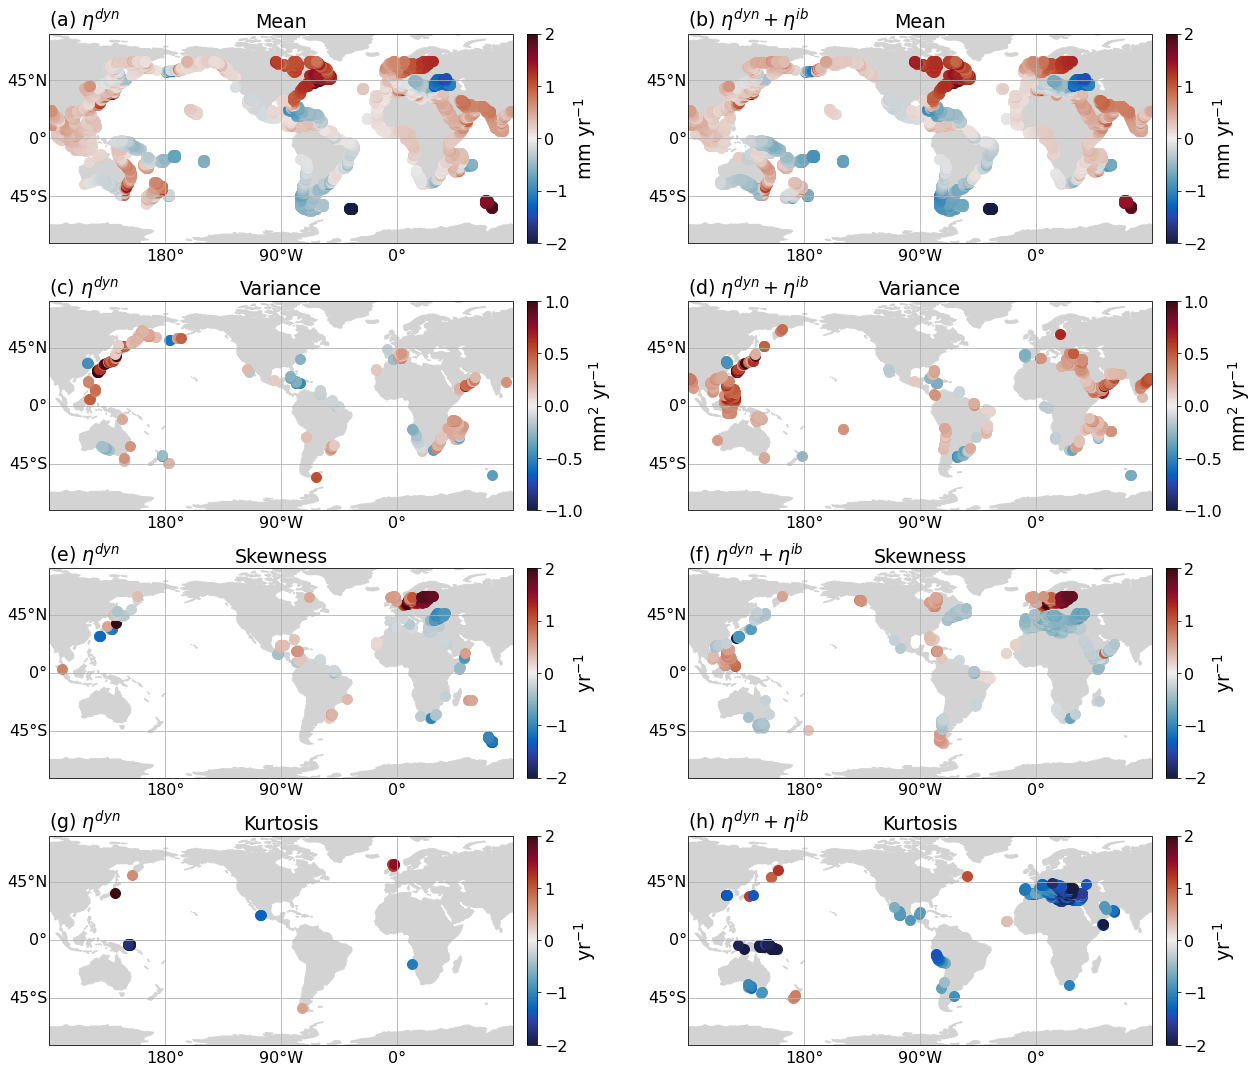

In [36]:
# "Global" parameters

# fontsize label colorbar
fontsize_cb = 19
# fontsize label colorbar ticks
fontsize_cb_ticks = 16
# fontsize lat and lon
font_lats_lons = 16
# size of points to plot
point_size = 100
# font of the title
fontsize_title = 19
vmin_MEAN = -2
vmax_MEAN = 2
vmin_VAR = -1
vmax_VAR = 1
vmin_SKEW = -2
vmax_SKEW = 2
vmin_KURT = -2
vmax_KURT = 2

fig = plt.figure(figsize=(20,15))

##################################### Mean

ax = fig.add_subplot(4, 2, 1, projection=ccrs.PlateCarree(central_longitude=-90))

# moment considered
moment = 0
coeffs_list = zos_only_sig_MEAN
label = '(a) $\eta^{dyn}$'
coords = zos_only_lat_long_coast_sig_MEAN

plot_tide_g(coords,coeffs_list,moment,vmin_MEAN,vmax_MEAN,label,ax)

##################################### Mean

ax = fig.add_subplot(4, 2, 2, projection=ccrs.PlateCarree(central_longitude=-90))

# moment considered
moment = 0
coeffs_list = zos_ib_sig_MEAN
label = '(b) $\eta^{dyn} + \eta^{ib}$'
coords = zos_ib_lat_long_coast_sig_MEAN

plot_tide_g(coords,coeffs_list,moment,vmin_MEAN,vmax_MEAN,label,ax)

##################################### Variance

ax = fig.add_subplot(4, 2, 3, projection=ccrs.PlateCarree(central_longitude=-90))

# moment considered
moment = 1
coeffs_list = zos_only_sig_VAR
label = '(c) $\eta^{dyn}$'
coords = zos_only_lat_long_coast_sig_VAR

plot_tide_g(coords,coeffs_list,moment,vmin_VAR,vmax_VAR,label,ax)

##################################### Variance

ax = fig.add_subplot(4, 2, 4, projection=ccrs.PlateCarree(central_longitude=-90))

# moment considered
moment = 1
coeffs_list = zos_ib_sig_VAR
label = '(d) $\eta^{dyn} + \eta^{ib}$'
coords = zos_ib_lat_long_coast_sig_VAR

plot_tide_g(coords,coeffs_list,moment,vmin_VAR,vmax_VAR,label,ax)

##################################### Skewness

ax = fig.add_subplot(4, 2, 5, projection=ccrs.PlateCarree(central_longitude=-90))

# moment considered
moment = 2
coeffs_list = zos_only_sig_SKEW
label = '(e) $\eta^{dyn}$'
coords = zos_only_lat_long_coast_sig_SKEW

plot_tide_g(coords,coeffs_list,moment,vmin_SKEW,vmax_SKEW,label,ax)

##################################### Skewness

ax = fig.add_subplot(4, 2, 6, projection=ccrs.PlateCarree(central_longitude=-90))

# moment considered
moment = 2
coeffs_list = zos_ib_sig_SKEW
label = '(f) $\eta^{dyn} + \eta^{ib}$'
coords = zos_ib_lat_long_coast_sig_SKEW

plot_tide_g(coords,coeffs_list,moment,vmin_SKEW,vmax_SKEW,label,ax)

##################################### Kurtosis

ax = fig.add_subplot(4, 2, 7, projection=ccrs.PlateCarree(central_longitude=-90))

# moment considered
moment = 3
coeffs_list = zos_only_sig_KURT
label = '(g) $\eta^{dyn}$'
coords = zos_only_lat_long_coast_sig_KURT

plot_tide_g(coords,coeffs_list,moment,vmin_KURT,vmax_KURT,label,ax)

##################################### Kurtosis

ax = fig.add_subplot(4, 2, 8, projection=ccrs.PlateCarree(central_longitude=-90))

# moment considered
moment = 3
coeffs_list = zos_ib_sig_KURT
label = '(h) $\eta^{dyn} + \eta^{ib}$'
coords = zos_ib_lat_long_coast_sig_KURT

plot_tide_g(coords,coeffs_list,moment,vmin_KURT,vmax_KURT,label,ax)

fig.tight_layout()

#plt.subplots_adjust(wspace=0, hspace=None)

#fig.savefig('./figures/1pctCO2_zos_p_values_05_blocks_season.eps',bbox_inches='tight')